# Data clean







## Estimating Rural Land Rent

We estimate rural land rent based on agricultural land productivity, using the GAEZ v4 dataset. Specifically, we use 2010 value of production data and adjust it to 2022 currency terms using the Consumer Price Index (CPI).

### GAEZ v4
https://gaez.fao.org/pages/data-access-download

https://gaez-services.fao.org/server/rest/services/res06/ImageServer

Aggregate Crop Production Value

Cropping decisions at farm level depend on biophysical conditions, product demand and economic criteria. The portal includes rasters showing aggregate crop production value, i.e., estimates of the spatial distribution of crop production valued at year 2000 international prices (GK$*), for the sum of 22 main crops and for three aggregate crop groups (cereals, oil crops, root crops). 

The GAEZ v4 dataset provides agricultural production values measured in **GK\$**, which are international price weights calculated by the FAO for the year 2000.

For crop groups that include a wide variety of crops (e.g., vegetables, stimulants, crops not elsewhere specified), a consistent set of international price weights—compiled by the FAO in year 2000 US dollars—was used to aggregate individual crop values. The total production volume is expressed in **1000 GK\$**.

Each crop's harvested area is recorded in **thousands of hectares**, and yields are reported either in **tons per hectare** or in **thousands of GK\$ per hectare**, depending on the unit used for total crop production.



#### Method: Deriving Land Productivity per Square Meter (in 2022 RMB)

This analysis is based on the `res06` raster layer from the **GAEZ v4** dataset provided by **FAO and IIASA**. The raster has a spatial resolution of **5 arc-minutes** (approximately **9 km × 9 km** at the equator) and uses **WGS84** geographic coordinates (**EPSG:4326**). Each pixel represents aggregated crop production value under specified agro-climatic conditions.

The original `value` field in the raster data is expressed in units of **1000 Geary-Khamis dollars (GK\$)**, a PPP-adjusted international price unit benchmarked to year 2000. The objective is to convert this value into **annual land productivity per square meter (in RMB, year 2022)**.



#### Conversion Steps:

1. **Unit restoration**
   Multiply `value` by 1000 to recover the actual value in GK\$.

   ```math
   value\_gk = value \times 1000
   ```

2. **Currency conversion**
   GK\$ ≈ USD (2000). Using the historical exchange rate of **1 USD = 8.28 RMB (in 2000)**:

   ```math
   value\_rmb\_2000 = value\_gk \times 8.28
   ```

3. **Inflation adjustment**
   The **CPI ratio** from 2000 to 2022 is used to convert to 2022 RMB:

   ```math
   CPI\_ratio = \prod_{t=2001}^{2022} \left( \frac{CPI_t}{100} \right) \approx {cpi_ratio:.4f}
   ```

4. **Pixel-level price in 2022 RMB**

   ```math
   price\_total\_area = value \times 1000 \times 8.28 \times CPI\_ratio
   ```

5. **Area correction (m² per pixel)**
   Since the raster uses geographic coordinates, pixel area varies by latitude. Each pixel's area is computed via spherical approximation:

   ```math
   area\_m2 = \left(111.32 \times \cos(\text{latitude}) \times 0.083333\right) \times \left(111.32 \times 0.083333\right) \times 10^6
   ```

6. **Final land productivity per square meter**

   ```math
   price\_m2 = \frac{price\_total\_area}{area\_m2}
   ```


#### Final Output

The resulting `price_m2` field represents the **estimated annual agricultural output per square meter**, expressed in **2022 Chinese yuan (RMB)**. This standardized measure allows for **spatial comparison of land productivity across China**.








In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

tif_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Raw/Gaze_2010/all_2010_val.tif"
with rasterio.open(tif_path) as src:
    print(src.profile)  # print the metadata of the raster file
    print(src.count)   # number of bands in the raster file
    data = src.read(1)           
    profile = src.profile         
    transform = src.transform    
    crs = src.crs                

data[data < -1e30] = np.nan   



{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.08333333333333333, 0.0, -180.0,
       0.0, -0.08333333333333333, 90.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
1


In [3]:
import pandas as pd
from rasterio.transform import xy

with rasterio.open(tif_path) as src:
    data = src.read(1)                
    transform = src.transform
    nodata_val = src.nodata

data = np.where(data == nodata_val, np.nan, data)

rows, cols = np.where(~np.isnan(data))
values = data[rows, cols]

lons, lats = xy(transform, rows, cols)

df = pd.DataFrame({
    "lon": lons,
    "lat": lats,
    "value": values
})


df.head()

# df.to_csv("maize_production_2015.csv", index=False)


,lon,lat,value
0,29.041667,70.875,2.402339
1,24.708333,70.625,1.592087
2,26.541667,70.625,0.660682
3,26.625000,70.625,8.401594
4,27.208333,70.625,5.189222


In [4]:
# approximate the bounding box of China
df_china = df.query("lon >= 73 and lon <= 136 and lat >= 18 and lat <= 54")
df_china = df_china.reset_index(drop=True)
df_china.head()

,lon,lat,value
0,73.041667,53.958333,282.186432
1,73.125000,53.958333,414.087646
2,73.208333,53.958333,436.086975
3,73.291667,53.958333,312.478302
4,73.375000,53.958333,285.594421


In [5]:
import numpy as np


def add_pixel_area(df):
    """
    Compute pixel area (in square meters) for GAEZ raster data based on latitude.
    Assumes a default spatial resolution of 5 arc-min × 5 arc-min 
    (≈ 0.083333° × 0.083333°) in EPSG:4326 coordinates.

    Parameters:
        df: A DataFrame containing a 'lat' column (in degrees).

    Returns:
        The input DataFrame with a new column 'area_m2' representing 
        the estimated surface area of each pixel in square meters.
    """
    # One degree of latitude ≈ 111.32 km
    deg_to_km = 111.32
    res_deg = 0.083333  # Angular resolution per pixel (5 arc-min)

    lat_rad = np.radians(df["lat"])
    dx_km = deg_to_km * np.cos(lat_rad) * res_deg  # Width in longitudinal direction
    dy_km = deg_to_km * res_deg                    # Height in latitudinal direction (constant)

    df["area_m2"] = dx_km * dy_km * 1e6  # Convert from km² to m²
    return df


df_china = add_pixel_area(df_china)  # Adds the 'area_m2' column
df_china.head()



,lon,lat,value,area_m2
0,73.041667,53.958333,282.186432,5.063298e+07
1,73.125000,53.958333,414.087646,5.063298e+07
2,73.208333,53.958333,436.086975,5.063298e+07
3,73.291667,53.958333,312.478302,5.063298e+07
4,73.375000,53.958333,285.594421,5.063298e+07


In [6]:
usd_to_rmb_2000 = 8.28      
# China's CPI ratio from 2000 to 2022
cpi_list = [ 100.7, 99.2, 101.2, 103.9, 101.8, 101.5,\
             104.8, 105.9, 99.3, 103.3, 105.4, 102.6,\
             102.6, 102.0, 101.4, 102.0, 101.6, 102.1,\
             102.9, 102.5, 100.9, 102.0]

cpi_ratio = 1.0
for cpi in cpi_list:
    cpi_ratio *= (cpi / 100)

print(f"2000 to 2022 CPI ratio: {cpi_ratio:.4f}")


df_china["price_tal_are"] = df_china["value"] * 1000 * usd_to_rmb_2000 * cpi_ratio

df_china["price_m2"] = df_china["price_tal_are"] / df_china["area_m2"] 

2000 to 2022 CPI ratio: 1.6285


In [8]:
df_china.head()

,lon,lat,value,area_m2,price_tal_are,price_m2
0,73.041667,53.958333,282.186432,5.063298e+07,3804941.5,0.075147
1,73.125000,53.958333,414.087646,5.063298e+07,5583469.0,0.110273
2,73.208333,53.958333,436.086975,5.063298e+07,5880103.0,0.116132
3,73.291667,53.958333,312.478302,5.063298e+07,4213390.0,0.083214
4,73.375000,53.958333,285.594421,5.063298e+07,3850893.5,0.076055


In [9]:
df_china_sorted = df_china.sort_values(by="value", ascending=False)
df_china_sorted = df_china_sorted.reset_index(drop=True)
df_china_sorted.head()

,lon,lat,value,area_m2,price_tal_are,price_m2
0,115.208333,36.875000,42845.246094,6.884009e+07,577716160.0,8.392148
1,112.375000,28.958333,39967.222656,7.529647e+07,538909440.0,7.157168
2,121.375000,30.958333,37795.210938,7.379648e+07,509622528.0,6.905784
3,120.208333,36.458333,37633.339844,6.921380e+07,507439840.0,7.331484
4,76.125000,39.541667,36661.875000,6.636299e+07,494340832.0,7.449044


In [10]:
df_china.describe()

,lon,lat,value,area_m2,price_tal_are,price_m2
count,157267.000000,157267.000000,157267.000000,1.572670e+05,1.572670e+05,157267.000000
mean,102.837836,35.603440,2862.908936,6.869266e+07,3.860285e+07,0.532087
std,17.790037,11.014249,4014.184570,9.800472e+06,5.412640e+07,0.755210
min,73.041667,18.041667,0.017789,5.063298e+07,2.398572e+02,0.000004
25%,85.375000,25.708333,120.762760,5.955394e+07,1.628339e+06,0.025816
50%,105.208333,34.041667,1230.795654,7.130852e+07,1.659578e+07,0.234544
75%,116.875000,46.208333,4116.320068,7.753753e+07,5.550358e+07,0.741643
max,135.958333,53.958333,42845.246094,8.182462e+07,5.777162e+08,8.392148


In [11]:
df_china.shape

(157267, 6)

In [12]:
df_china.to_csv("/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/agr_val_2022.csv", index=False)

## Matching Residential Communities with Provincial and Municipal Boundaries (Using 2020 Administrative Map)

A small number of residential community points could not be matched to the administrative boundaries. This is likely due to slight inaccuracies in geolocation coordinates obtained from Gaode or Baidu Maps. However, since the unmatched portion is extremely small, we chose to drop them.

* **Successfully matched data points:** 899,161
* **Unmatched data points:** 135
* **Total data points:** 899,296
* **Match rate:** 99.98%

Given the high match rate, the unmatched data points were excluded from further analysis.

In [230]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

community_csv_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Raw/community_loc_hp.csv"
admin_shp_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Raw/China_Adm_2020/China2020County.shp"
output_csv_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/house_price.csv"
unmatched_csv_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/house_price_unmatched.csv"

# transform the community data into a geodataframe
df = pd.read_csv(community_csv_path)
gdf_community = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["lng84"], df["lat84"]),
    crs="EPSG:4326"
)

# check if the CRS of the community data is the same as the admin data
gdf_admin = gpd.read_file(admin_shp_path)
if gdf_admin.crs != gdf_community.crs:
    gdf_admin = gdf_admin.to_crs(gdf_community.crs)


In [231]:
# consider the points that are on the boundary of the polygons
gdf_joined_all = gpd.sjoin(gdf_community, gdf_admin, how="left", predicate="intersects")
gdf_joined_first = gdf_joined_all.sort_values(by="index_right").drop_duplicates(subset="id")

In [65]:
pd.set_option('display.max_columns', None)

In [66]:
gdf_joined_all.head(3)

,id,名称,城市,区县,乡镇,建筑年份,类型,地址,lng84,lat84,供热,容积率,面积,总户数,类型.1,供水,得分,月份,环比,价格,geometry,index_right,地名,区划码,县级,县级码,县级类,地级,地级码,地级类,省级,省级码,省级类,曾用名,备注,ENG_NAME,VAR_NAME,code,NAME_3,VAR_NAME3,GID_3,TYPE_3,NAME_2,VAR_NAME2,GID_2,TYPE_2,NAME_1,VAR_NAME1,GID_1,TYPE_1,year
0,1,万科惠斯勒小镇,鞍山,铁东,明达,2015,多层|高层,湖南街202号,123.026172,41.079107,1.0,NaN,NaN,2564,公寓住宅,民用,7.3,12,0.59,8120.0,POINT (123.02617 41.07911),2778.0,铁东区,210302.0,铁东区,210302.0,市辖区,鞍山市,210300.0,地级市,辽宁省,210000.0,省,None,None,Tiedong,Tiě Dōng,210302.0,Tiedong,TiěDōng,210302.0,District?,Anshan,ān Shān,210300.0,Prefecture City?,Liaoning,Liáo?Níng,210000.0,Province,2020.0
1,2,万科金域华府,鞍山,铁东,明达,NaN,多层|小高层|高层,湖南街202号,123.031468,41.078385,1.0,NaN,NaN,2294,公寓住宅,民用,6.6,12,0.88,9803.0,POINT (123.03147 41.07839),2778.0,铁东区,210302.0,铁东区,210302.0,市辖区,鞍山市,210300.0,地级市,辽宁省,210000.0,省,None,None,Tiedong,Tiě Dōng,210302.0,Tiedong,TiěDōng,210302.0,District?,Anshan,ān Shān,210300.0,Prefecture City?,Liaoning,Liáo?Níng,210000.0,Province,2020.0
2,3,公园1号,鞍山,铁东,明达,NaN,多层|高层,解放东路455号,123.015271,41.067638,1.0,NaN,NaN,1653,公寓住宅,民用,7.1,12,-0.39,5953.0,POINT (123.01527 41.06764),2778.0,铁东区,210302.0,铁东区,210302.0,市辖区,鞍山市,210300.0,地级市,辽宁省,210000.0,省,None,None,Tiedong,Tiě Dōng,210302.0,Tiedong,TiěDōng,210302.0,District?,Anshan,ān Shān,210300.0,Prefecture City?,Liaoning,Liáo?Níng,210000.0,Province,2020.0


In [232]:

gdf_joined_first = gdf_joined_first.rename(columns={
    "NAME_1": "province",
    "NAME_2": "city",
    "NAME_3": "county"
})


columns_to_keep = df.columns.tolist() + ["province", "city", "county"]
df_matched = gdf_joined_first[columns_to_keep]
df_unmatched = df_matched[df_matched["province"].isna()] 
df_matched_final = df_matched[df_matched["province"].notna()]

total_count = len(df)
matched_count = len(df_matched_final)
unmatched_count = len(df_unmatched)
print("successfully matched data points:", matched_count)
print("unmatched data points:", unmatched_count)
print("total data points:", total_count)
print("matched rate:{:.2f}%".format(100 * matched_count / total_count))




successfully matched data points: 899161
unmatched data points: 135
total data points: 899296
matched rate:99.98%


### Check unmatched data

In [68]:
df_unmatched.head(3)

,id,名称,城市,区县,乡镇,建筑年份,类型,地址,lng84,lat84,供热,容积率,面积,总户数,类型.1,供水,得分,月份,环比,价格,province,city,county
33663,33664,招商马尔贝拉(别墅),北京,北京周边,烟台,2021,低层,海滨路277号,121.141192,37.601678,NaN,40.0,NaN,206,别墅,民用,7.2,12,0.0,16700.0,NaN,NaN,NaN
34520,34521,海关街小区,北京,北京周边,烟台,2007,多层,海关街,121.395177,37.544510,1.0,30.0,NaN,30,公寓住宅,民用,7.4,12,0.0,13900.0,NaN,NaN,NaN
34701,34702,曦岛度假公寓,北京,北京周边,烟台,2000,多层,海景路9号,121.226967,36.694253,1.0,30.0,NaN,0,商住楼,商用,7.0,12,0.0,4800.0,NaN,NaN,NaN


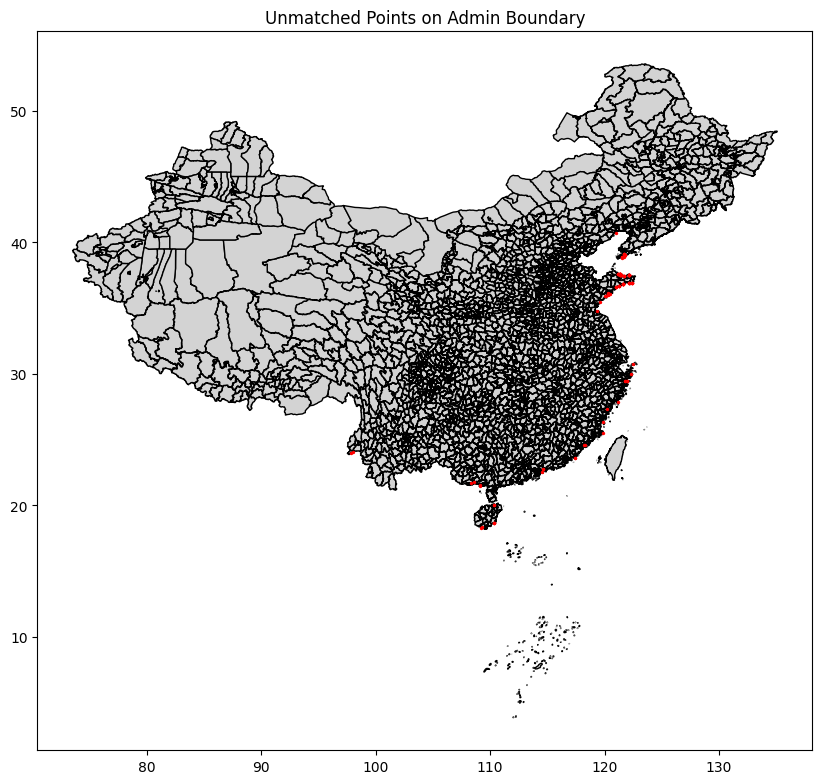

In [69]:
import matplotlib.pyplot as plt


gdf_unmatched = gpd.GeoDataFrame(
    df_unmatched,
    geometry=gpd.points_from_xy(df_unmatched["lng84"], df_unmatched["lat84"]),
    crs="EPSG:4326"
)

base = gdf_admin.plot(color='lightgrey', edgecolor='black', figsize=(10, 10))
gdf_unmatched.plot(ax=base, color='red', markersize=2)
plt.title("Unmatched Points on Admin Boundary")
plt.show()



### Checking the Number of Cities

For most data points, the city is identified in the `province-city` format. In cases where city-level information is missing—such as in direct-administered municipalities or certain provinces—we substitute with `province-county` identifiers. If both city and county information are unavailable, the data point is dropped from the analysis.

Number of unique province-city combinations: 444


In [233]:

df_matched_final["city"] = df_matched_final["city"].replace(["NULL", "null", "", "NaN", "nan"], pd.NA)


def generate_prov_city(row):
    if pd.notna(row["city"]):
        return f"{row['province']}-{row['city']}"
    elif pd.notna(row["county"]):
        return f"{row['province']}-{row['county']}"
    else:
        return pd.NA 

df_matched_final["prov_city"] = df_matched_final.apply(generate_prov_city, axis=1)

df_matched_final = df_matched_final.dropna(subset=["prov_city"]).copy()

unique_cities = df_matched_final["prov_city"].nunique()
print(f" Number of unique province-city combinations: {unique_cities}")


prov_city_list = df_matched_final["prov_city"].drop_duplicates().sort_values().tolist()
print(prov_city_list)



/var/folders/4g/6_8lhyp147394q93651p5kyw0000gn/T/ipykernel_63305/95942492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matched_final["city"] = df_matched_final["city"].replace(["NULL", "null", "", "NaN", "nan"], pd.NA)
/var/folders/4g/6_8lhyp147394q93651p5kyw0000gn/T/ipykernel_63305/95942492.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matched_final["prov_city"] = df_matched_final.apply(generate_prov_city, axis=1)


 Number of unique province-city combinations: 444
['Anhui-Anqing', 'Anhui-Bengbu', 'Anhui-Bozhou', 'Anhui-Chizhou', 'Anhui-Chuzhou', 'Anhui-Fuyang', 'Anhui-Hefei', 'Anhui-Huaibei', 'Anhui-Huainan', 'Anhui-Huangshan', 'Anhui-Liuan', 'Anhui-Maanshan', 'Anhui-Suzhou', 'Anhui-Tongling', 'Anhui-Wuhu', 'Anhui-Xuancheng', 'Beijing-Changping', 'Beijing-Chaoyang', 'Beijing-Daxing', 'Beijing-Dongcheng', 'Beijing-Fangshan', 'Beijing-Fengtai', 'Beijing-Haidian', 'Beijing-Huairou', 'Beijing-Mentougou', 'Beijing-Miyun', 'Beijing-Pinggu', 'Beijing-Shijingshan', 'Beijing-Shunyi', 'Beijing-Tongzhou', 'Beijing-Xicheng', 'Beijing-Yanqing', 'Chongqing-Banan', 'Chongqing-Beibei', 'Chongqing-Bishan', 'Chongqing-Changshou', 'Chongqing-Chengkou', 'Chongqing-Dadukou', 'Chongqing-Dazu', 'Chongqing-Dianjiang', 'Chongqing-Fengdu', 'Chongqing-Fengjie', 'Chongqing-Fuling', 'Chongqing-Hechuan', 'Chongqing-Jiangbei', 'Chongqing-Jiangjin', 'Chongqing-Jiulongpo', 'Chongqing-Kaizhou', 'Chongqing-Liangping', 'Chongqing-N

In [234]:
# Save the matched and unmatched data to CSV files
df_matched_final.to_csv(output_csv_path, index=False)
df_unmatched.to_csv(unmatched_csv_path, index=False)
print(f" matched data saved to: {output_csv_path}")
print(f" unmatched data saved to: {unmatched_csv_path}")

 matched data saved to: /Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/house_price.csv
 unmatched data saved to: /Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/house_price_unmatched.csv


In [228]:
df_matched_final.shape

(899161, 24)


## Retaining Data Points Within Built-Up Areas

Using the 2020 built-up area map, we retain only the residential community points located within built-up areas, treating them as urban housing price points.

### Merging Built-Up Area Shapefiles

The built-up area data is stored by province, with each provincial folder containing shapefiles for cities with populations over 300,000. To facilitate filtering, I first merged all these files into a single shapefile.


In [ ]:
import geopandas as gpd
import pandas as pd
import os
from tqdm import tqdm  

root_folder = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Raw/China_BuiltUp_300kCities_2020"
output_folder = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/China_BuiltUp_300kCities_2020"
output_shp_path = os.path.join(output_folder, "China_BuiltUp_300kCities_2020.shp")

os.makedirs(output_folder, exist_ok=True)

gdf_list = []
error_files = []

all_target_files = []
for province in os.listdir(root_folder):
    province_path = os.path.join(root_folder, province)
    if os.path.isdir(province_path):
        for filename in os.listdir(province_path):
            if filename.endswith("2020_new_Urb.shp"):
                all_target_files.append((province, filename))

for province, filename in tqdm(all_target_files, desc="Processing cities"):
    province_path = os.path.join(root_folder, province)
    full_path = os.path.join(province_path, filename)
    try:
        gdf = gpd.read_file(full_path)
        gdf = gdf.to_crs("EPSG:4326")
        gdf["province"] = province
        gdf["city"] = filename.replace("2020_new_Urb.shp", "")
        gdf_list.append(gdf)
    except Exception as e:
        error_files.append((province, filename, str(e)))


if gdf_list:
    gdf_all = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True), crs=gdf_list[0].crs)
    gdf_all.to_file(output_shp_path)
    print(f"\n successfully saved to {output_shp_path}")
else:
    print("\n No shapefiles found in the specified directory.")


if error_files:
    print("\n the following files failed to read:")
    for prov, fname, err in error_files:
        print(f"- {prov}/{fname} :{err}")
else:
    print("\n all files read successfully.")



### Matching Residential Communities Located Within Built-Up Areas

After merging the built-up area shapefiles, we perform a spatial join between the previously filtered `house_price.csv` and the merged shapefile `China_BuiltUp_300kCities_2020.shp`. This allows us to identify and retain only those housing price points that fall within urban (built-up) areas. The matched urban points are saved in `builtup_hp.csv` and serve as the final dataset for urban housing prices.

It is worth noting that the built-up area dataset only includes cities with populations over 300,000. As a result, some residential communities are excluded from the final sample. The matching results are as follows:

* **Successfully matched data points:** 579,328
* **Total data points:** 899,161
* **Match rate:** 64.43%

Since we later use floor area ratio (FAR) to estimate the share of land in housing output (i.e., the production elasticity of land, denoted by $\alpha$), we drop any data points with missing FAR before saving the final dataset. After this filtering step, **413,957** observations remain.



In [237]:

house_price_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/house_price.csv"
builtup_shp_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/China_BuiltUp_300kCities_2020/China_BuiltUp_300kCities_2020.shp"
output_builtup_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/builtup_hp.csv"


df_hp = pd.read_csv(house_price_path)
gdf_hp = gpd.GeoDataFrame(
    df_hp,
    geometry=gpd.points_from_xy(df_hp["lng84"], df_hp["lat84"]),
    crs="EPSG:4326"
)


gdf_builtup = gpd.read_file(builtup_shp_path)
if gdf_hp.crs != gdf_builtup.crs:
    gdf_builtup = gdf_builtup.to_crs(gdf_hp.crs)

gdf_hp_builtup = gpd.sjoin(gdf_hp, gdf_builtup, how="inner", predicate="intersects")


matched_count = len(gdf_hp_builtup)
total_count = len(gdf_hp)
print(f"successfully matched data points: {matched_count}")
print(f"total data points: {total_count}")
print(f"matched rate:{100 * matched_count / total_count:.2f}%")




/opt/anaconda3/envs/midway-debug/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/China_BuiltUp_300kCities_2020/China_BuiltUp_300kCities_2020.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


successfully matched data points: 579328
total data points: 899161
matched rate:64.43%


In [238]:

gdf_hp_builtup = gdf_hp_builtup.rename(columns={
    "province_left": "province",
    "city_left": "city"
})

cols_to_keep = df_hp.columns.tolist()
gdf_result = gdf_hp_builtup[cols_to_keep]


In [239]:
unmatched = gdf_hp[~gdf_hp["id"].isin(gdf_hp_builtup["id"])]
unmatched = unmatched.drop(columns=["geometry"])
unmatched.to_csv("/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/builtup_hp_unmatched.csv", index=False)

print(f"unmatched data points: {len(unmatched)}")

unmatched data points: 320207


In [179]:
gdf_result.columns

Index(['id', '名称', '城市', '区县', '乡镇', '建筑年份', '类型', '地址', 'lng84', 'lat84',
       '供热', '容积率', '面积', '总户数', '类型.1', '供水', '得分', '月份', '环比', '价格',
       'province', 'city', 'county', 'prov_city'],
      dtype='object')

In [180]:
gdf_result.shape

(579328, 24)

In [243]:
gdf_result = gdf_result[gdf_result['容积率'].notna()]
gdf_result.shape

(413957, 24)

In [244]:
gdf_result.to_csv(output_builtup_path, index=False)
print(f" successfully saved to {output_builtup_path}")

 successfully saved to /Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/builtup_hp.csv



### Checking the Number of Matched Residential Communities by City

To avoid confusion caused by cities with the same name, we distinguish them using a combined `prov_city` identifier.

Since we later estimate the share of land in housing output (i.e., the production elasticity of land, denoted by $\alpha$) by regressing housing prices on floor area ratio (FAR), we restrict the sample to cities with **more than 50 valid housing price observations**. After this filtering step, **214 cities/counties** remain in the final dataset.



In [245]:
gdf_result.head(3)

,id,名称,城市,区县,乡镇,建筑年份,类型,地址,lng84,lat84,供热,容积率,面积,总户数,类型.1,供水,得分,月份,环比,价格,province,city,county,prov_city
338,7536,银河花园,阿克苏,阿克苏市,阿克苏城区,2003,多层,南大街691号,80.266866,41.151785,NaN,42.0,NaN,0,公寓住宅,民用,7.4,12,0.0,4216.0,Xinjiang,Akesu,Akesu,Xinjiang-Akesu
348,7507,康馨苑,阿克苏,阿克苏市,阿克苏城区,2006,多层,乌喀路,80.274909,41.151644,NaN,20.0,NaN,0,公寓住宅,民用,7.6,12,0.0,4500.0,Xinjiang,Akesu,Akesu,Xinjiang-Akesu
351,7510,东风小区,阿克苏,阿克苏市,阿克苏城区,2000,多层,乌喀路,80.279145,41.155231,NaN,65.0,NaN,0,公寓住宅,民用,7.8,12,0.0,3896.0,Xinjiang,Akesu,Akesu,Xinjiang-Akesu


In [246]:
gdf_result.shape

(413957, 24)

In [247]:
gdf_result['prov_city'].nunique()

314

In [248]:

city_counts = gdf_result.groupby("prov_city").size().reset_index(name="count")

city_counts_inc = city_counts.sort_values(by="count", ascending=True)

city_counts_inc.head()


,prov_city,count
147,Hubei-Xianning,1
274,Sichuan-Neijiang,1
277,Sichuan-Ziyang,1
205,Liaoning-Yingkou,1
184,Jiangxi-Yichun,1


In [249]:
city_counts_dec = city_counts.sort_values(by="count", ascending=False)
city_counts_dec.head()

,prov_city,count
264,Sichuan-Chengdu,16492
229,Shandong-Yantai,14208
59,Guangdong-Guangzhou,11755
145,Hubei-Wuhan,9176
6,Anhui-Hefei,9083


In [250]:
city_counts = gdf_result.groupby("prov_city").size().reset_index(name="count")

city_counts_inc = city_counts.sort_values(by="count", ascending=True)

city_counts_inc.head(10)

,prov_city,count
147,Hubei-Xianning,1
274,Sichuan-Neijiang,1
277,Sichuan-Ziyang,1
205,Liaoning-Yingkou,1
184,Jiangxi-Yichun,1
92,Guizhou-Liupanshui,1
212,Neimenggu-Wuhai,1
142,Hubei-Shiyan,1
178,Jiangxi-Jian,1
180,Jiangxi-Jiujiang,2


In [251]:
city_counts.describe()

,count
count,314.000000
mean,1318.334395
std,2260.215765
min,1.000000
25%,33.750000
50%,188.000000
75%,1542.250000
max,16492.000000


In [252]:
city_counts= city_counts[city_counts["count"] > 50]
city_counts.shape

(214, 2)

In [253]:
city_counts_inc = city_counts.sort_values(by="count", ascending=True)
city_counts_inc.head(10)

,prov_city,count
204,Liaoning-Tieling,52
196,Liaoning-Dandong,52
143,Hubei-Suizhou,53
192,Liaoning-Anshan,53
246,Shanxi-Ankang,53
95,Guizhou-Zunyi,56
201,Liaoning-Liaoyang,56
139,Hubei-Jingmen,57
121,Henan-Jiyuan,58
64,Guangdong-Maoming,58


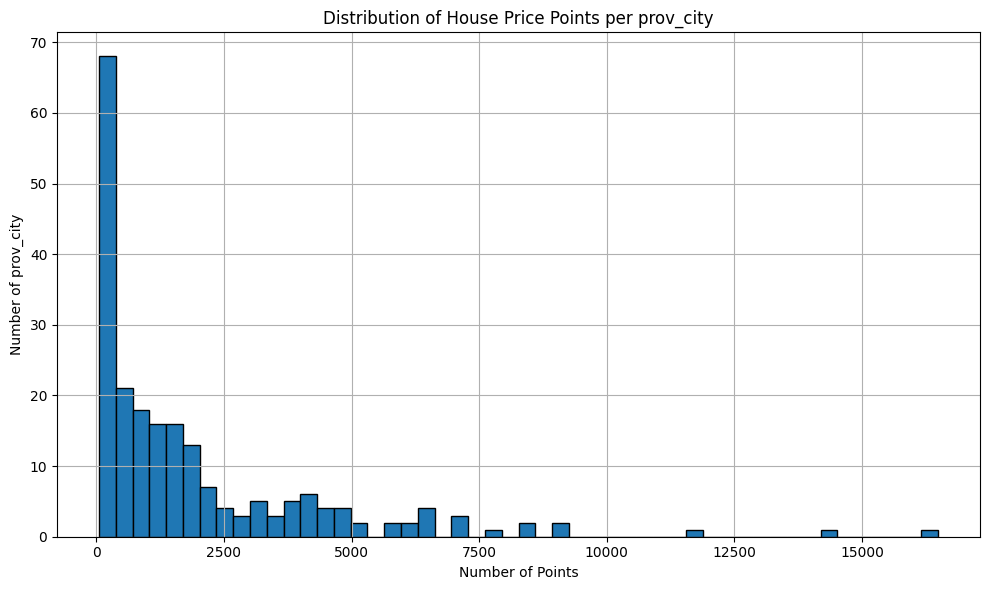

the first bin: 52.0-380.8


In [254]:

import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(city_counts["count"], bins=50, edgecolor="black")
plt.title("Distribution of House Price Points per prov_city")
plt.xlabel("Number of Points")
plt.ylabel("Number of prov_city")
plt.grid(True)
plt.tight_layout()
plt.show()


print(f"the first bin: {bins[0]}-{bins[1]}")



## Saving Data by City

We group the data in `builtup_hp.csv` by the `prov_city` identifier and save each group as a separate CSV file named `prov_city_hp.csv`. These files are stored in the `City_hp` folder. This structure facilitates parallel processing in subsequent tasks, including land rent estimation, land rent curve fitting, and welfare loss calculations related to policy evaluation.


In [255]:

input_csv = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/builtup_hp.csv"
output_folder = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/City_hp"

os.makedirs(output_folder, exist_ok=True)

df = pd.read_csv(input_csv)


city_counts = df["prov_city"].value_counts()
valid_cities = city_counts[city_counts >= 50].index
print(f"number of valid cities: {len(valid_cities)}")

df = df[df["prov_city"].isin(valid_cities)]


def safe_filename(name):
    return name.replace("/", "_").replace(" ", "").replace("\\", "_")


for prov_city, group in df.groupby("prov_city"):
    filename = f"{safe_filename(prov_city)}_hp.csv"
    output_path = os.path.join(output_folder, filename)
    group.to_csv(output_path, index=False)


print(f"in total {len(df)} points, {len(valid_cities)} cities with more than 50 points")



number of valid cities: 214
in total 412147 points, 214 cities with more than 50 points


## Check prov_city or prov_county

In [ ]:

def check_city_hp_directory(city_hp_dir: str, gdf_all: gpd.GeoDataFrame):


    prov_city_pairs = set(zip(
        gdf_all['province'].astype(str).str.strip().str.lower(),
        gdf_all['city'].astype(str).str.strip().str.lower()
    ))

    prov_county_pairs = set(zip(
        gdf_all['province'].astype(str).str.strip().str.lower(),
        gdf_all['county'].astype(str).str.strip().str.lower()
    ))


    valid_pairs = prov_city_pairs.union(prov_county_pairs)

    mismatches = {}
    for fname in os.listdir(city_hp_dir):
        if not fname.endswith('_hp.csv'):
            continue

        base = fname[:-len('_hp.csv')]
        try:
            prov, city = base.split('-', 1)
            prov = prov.strip().lower()
            city = city.strip().lower()
        except ValueError:
            mismatches[fname] = {
                'filename_match': False,
                'content_match': False,
                'invalid_content_values': {base}
            }
            continue
        
        filename_match = (prov.strip(), city.strip()) in valid_pairs
        if not filename_match:
            mismatches[fname] = {
                'filename_match': False,
                'content_match': False,
                'invalid_content_values': {base}
            }
            continue
    return mismatches 
city_hp_dir = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/City_hp"

report = check_city_hp_directory(city_hp_dir, gdf_joined_first)
for fname, result in report.items():
    if not result['filename_match'] or not result['content_match']:
        print(f" {fname}: filename_match={result['filename_match']}, "
                f"content_match={result['content_match']}, "
                f"invalid_values={result['invalid_content_values']}")

if all(r['filename_match'] and r['content_match'] for r in report.values()):
    print("all files are valid.")


all files are valid
